# Smoke Estimate and Economic Impact Analysis: Butte County, CA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

## Load and Clean Employment Data
 - Three datasets were loaded:
     - `CES_1990_2001.csv`
     - `CES_2002_2013.csv`
     - `CES_2014_2024.csv`
   - These were concatenated into a single DataFrame for a comprehensive view of employment trends, from 1990 to 2024.

In [2]:
df1 = pd.read_csv('data/CES_1990_2001.csv')
df2 = pd.read_csv('data/CES_2002_2013.csv')
df3 = pd.read_csv('data/CES_2014_2024.csv')

emp_df = pd.concat([df1, df2, df3])

In [3]:
# filter to Butte County
butte_emp_df = emp_df[emp_df['Area Name'] == 'Butte County'].copy()
print("butte_emp_df has {} rows".format(len(butte_emp_df)))

butte_emp_df has 11890 rows


Seasonal adjustments help remove recurring patterns (e.g., holiday or harvest employment spikes) to better reflect underlying trends.
We use seasonal adjusted data if available.


In [4]:
seasonally_adjusted_df = butte_emp_df[butte_emp_df['Seasonally Adjusted (Y/N)'] == 'Y']
non_seasonally_adjusted_df = butte_emp_df[butte_emp_df['Seasonally Adjusted (Y/N)'] == 'N']

seasonally_adjusted_butte_emp_df = pd.DataFrame()

for _, group in butte_emp_df.groupby(['Date', 'Series Code']):
    # check if there is seasonally adjusted data in the group
    seasonally_adjusted_data = group[group['Seasonally Adjusted (Y/N)'] == 'Y']
    
    if not seasonally_adjusted_data.empty:
        # if seasonally adjusted data is available, use seasonally adjusted data
        seasonally_adjusted_butte_emp_df = pd.concat([seasonally_adjusted_butte_emp_df, seasonally_adjusted_data])
    else:
        seasonally_adjusted_butte_emp_df = pd.concat([seasonally_adjusted_butte_emp_df, group])

seasonally_adjusted_butte_emp_df = seasonally_adjusted_butte_emp_df.reset_index(drop=True)

seasonally_adjusted_butte_emp_df is monthly, we aggregate to yearly.

In [5]:
yearly_butte_emp_df = seasonally_adjusted_butte_emp_df.groupby(['Year', 'Series Code', 'Industry Title']).agg({
    'Current Employment': 'mean'
}).reset_index()

yearly_butte_emp_df['Current Employment'] = yearly_butte_emp_df['Current Employment'].round()

yearly_butte_emp_df.head(3) # all industry employment data for each year from 1990 to 2024

,Year,Series Code,Industry Title,Current Employment
0,1990,0,Total Nonfarm,58217.0
1,1990,1000000,"Total, All Industries",61350.0
2,1990,5000000,Total Private,45142.0


In [6]:
print("yearly_butte_emp_df has {} rows, summarizing annual average employment by industry for Butte County.".format(len(yearly_butte_emp_df)))

yearly_butte_emp_df has 964 rows, summarizing annual average employment by industry for Butte County.


## Load and Clean Smoke Estimate Data

To analyze smoke estimates from wildfires in the Chico, CA region, we:
- Load and filter fire data we prepared from common analysis, considering:
    * the last 60 years of wildland fire data (1964-2024)
    * fires that are within 650 miles of Chico, CA
    * the annual fire season as running from May 1st through October 31st


- Calculate a smoke estimate for each wildfire based on the area burned, distance to Chico, and fire type:
    * A custom function `calculate_smoke_estimate` was applied to each row of the dataset. This function calculates the smoke estimate based on:
         - **Fire Type**: Different fire types are weighted based on their anticipated contribution to smoke emissions.
         - **Area Burned**: The number of acres burned in the fire.
         - **Distance**: The distance from Chico, with closer fires contributing more to the smoke estimate.
    * The smoke estimate is calculated as:


$$
\text{smoke_estimate} = \frac{\text{area_burned} \times \text{fire_type_weight}}{\text{distance}}
$$
     
- Aggregate the smoke estimates to yearly totals.


In [7]:
fire_df = pd.read_csv("../common_analysis/data/fire_data_checkpoint.csv")

start_year = 1964
end_year = 2024

# fitler to last 60 years
filtered_fire_df = fire_df[(fire_df['Fire_Year'] >= start_year) & (fire_df['Fire_Year'] <= end_year)]

# filter to within 650 miles of Chico
filtered_fire_df['Distance'] = pd.to_numeric(filtered_fire_df['Distance'])
filtered_fire_df = filtered_fire_df[filtered_fire_df['Distance'] <= 650]


def calculate_smoke_estimate(row):
    """
    A function for calculating smoke estimate for each wild fire.
    """
    
    # These fire type ranking weights help quantify the contribution of each fire type to the smoke estimate. 
    # The higher the weight, the greater the anticipated smoke emissions from that fire type. 
    fire_type_ranking = {
        'Wildfire': 1.0,  
        'Likely Wildfire': 0.8,
        'Unknown - Likely Wildfire': 0.6,
        'Prescribed Fire': 0.4,
        'Unknown - Likely Prescribed Fire': 0.2,  
    }
    
    area_burned = row['GIS_Acres'] 
    fire_type = row['Fire_Type']  
    distance = row['Distance']
    
    fire_type_weight = fire_type_ranking.get(fire_type, 0)  # default is 0 if fire type not found
    
    smoke_estimate = (area_burned * fire_type_weight) / (distance)

    return smoke_estimate


filtered_fire_df['Smoke_Estimates'] = filtered_fire_df.apply(
    lambda x: calculate_smoke_estimate(x), axis=1)

# aggregate to yearly smoke estimate data
smoke_df = filtered_fire_df.groupby('Fire_Year').agg({'Smoke_Estimates': 'sum'}).reset_index()
smoke_df.head(3)

,Fire_Year,Smoke_Estimates
0,1964,4428.377767
1,1965,1225.582319
2,1966,3397.148320


## Merge smoke data and employment data

In [8]:
merged_df = pd.merge(yearly_butte_emp_df, smoke_df, how='left', 
                     left_on='Year', right_on='Fire_Year')


merged_df = merged_df[['Year', 'Industry Title', 'Current Employment', 'Smoke_Estimates']]

# drop rows where Smoke_Estimates is NaN
merged_df = merged_df.dropna(subset=['Smoke_Estimates'])

merged_df.head(3)

,Year,Industry Title,Current Employment,Smoke_Estimates
0,1990,Total Nonfarm,58217.0,10033.167178
1,1990,"Total, All Industries",61350.0,10033.167178
2,1990,Total Private,45142.0,10033.167178


## Industry Employment and Smoke Estimates: All Industry Data Comparison

We first compare **Current Employment** in "Total, All Industries" with **Smoke Estimates** over time (from 1990 to 2024) to assess trends and potential relationships between employment and wildfire smoke exposure.

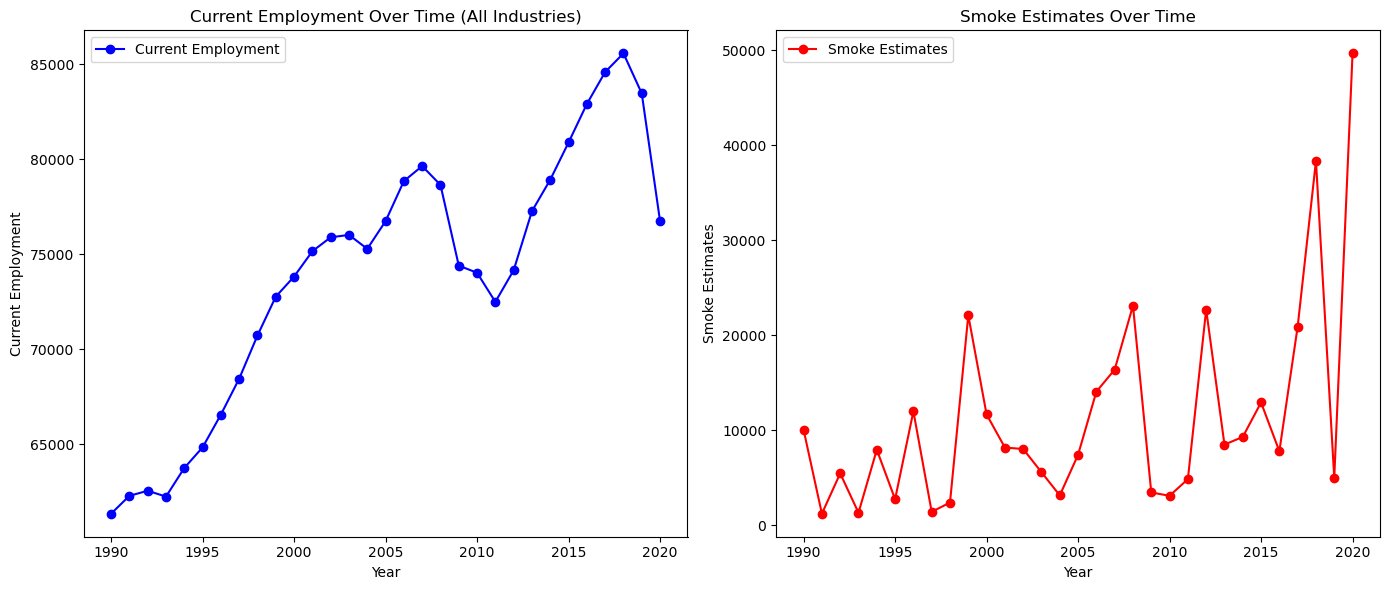

In [9]:
# filter to all industry employment data
all_industry_df = merged_df[merged_df['Industry Title'] == 'Total, All Industries']

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

axes[0].plot(all_industry_df['Year'], all_industry_df['Current Employment'], label='Current Employment', color='b', marker='o')
axes[0].set_title('Current Employment Over Time (All Industries)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Current Employment')
axes[0].legend()

axes[1].plot(all_industry_df['Year'], all_industry_df['Smoke_Estimates'], label='Smoke Estimates', color='r', marker='o')
axes[1].set_title('Smoke Estimates Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Smoke Estimates')
axes[1].legend()

plt.tight_layout()
plt.show()


* There is an overall increasing trend in employment across all industries from 1990 until around 2007. After 2007, the employment trend became more unstable, with noticeable declines around 2011 and 2020.

*  The smoke estimates show significant variability, with a high degree of fluctuation over the years. There are notable peaks around the years 1999, 2008, 2012, 2018, and 2020, which might correspond to major wildfire events such as the 2018 Camp Fire in Northern California, and the 2020 North Complex Fire.

In [10]:
# the county's primary industries (top 10)
industry_total_employment = merged_df.groupby('Industry Title')['Current Employment'].sum()

# filter out industries that include the word "Total"
filtered_industries = industry_total_employment[~industry_total_employment.index.str.contains("Total", case=False)]

top_10_industries = filtered_industries.sort_values(ascending=False).head(10).index.tolist()
print("Butte county's top 10 industries are: {}".format(top_10_industries))

Butte county's top 10 industries are: ['Service-Providing', 'Private Service Providing', 'Government', '      Private Education and Health Services', 'Trade, Transportation, and Utilities', 'Local Government', 'Retail Trade', 'Goods Producing', '      Leisure and Hospitality', '      Professional and Business Services']


In [11]:
filtered_industries.sort_values(ascending=False).head(10)

Industry Title
Service-Providing                              1971349.0
Private Service Providing                      1485176.0
Government                                      486176.0
      Private Education and Health Services     437877.0
Trade, Transportation, and Utilities            415275.0
Local Government                                349975.0
Retail Trade                                    303216.0
Goods Producing                                 230736.0
      Leisure and Hospitality                   225374.0
      Professional and Business Services        165934.0
Name: Current Employment, dtype: float64

In [12]:
# filter merged_df to top 10 industries only
filtered_merged_df = merged_df[merged_df['Industry Title'].isin(top_10_industries)]

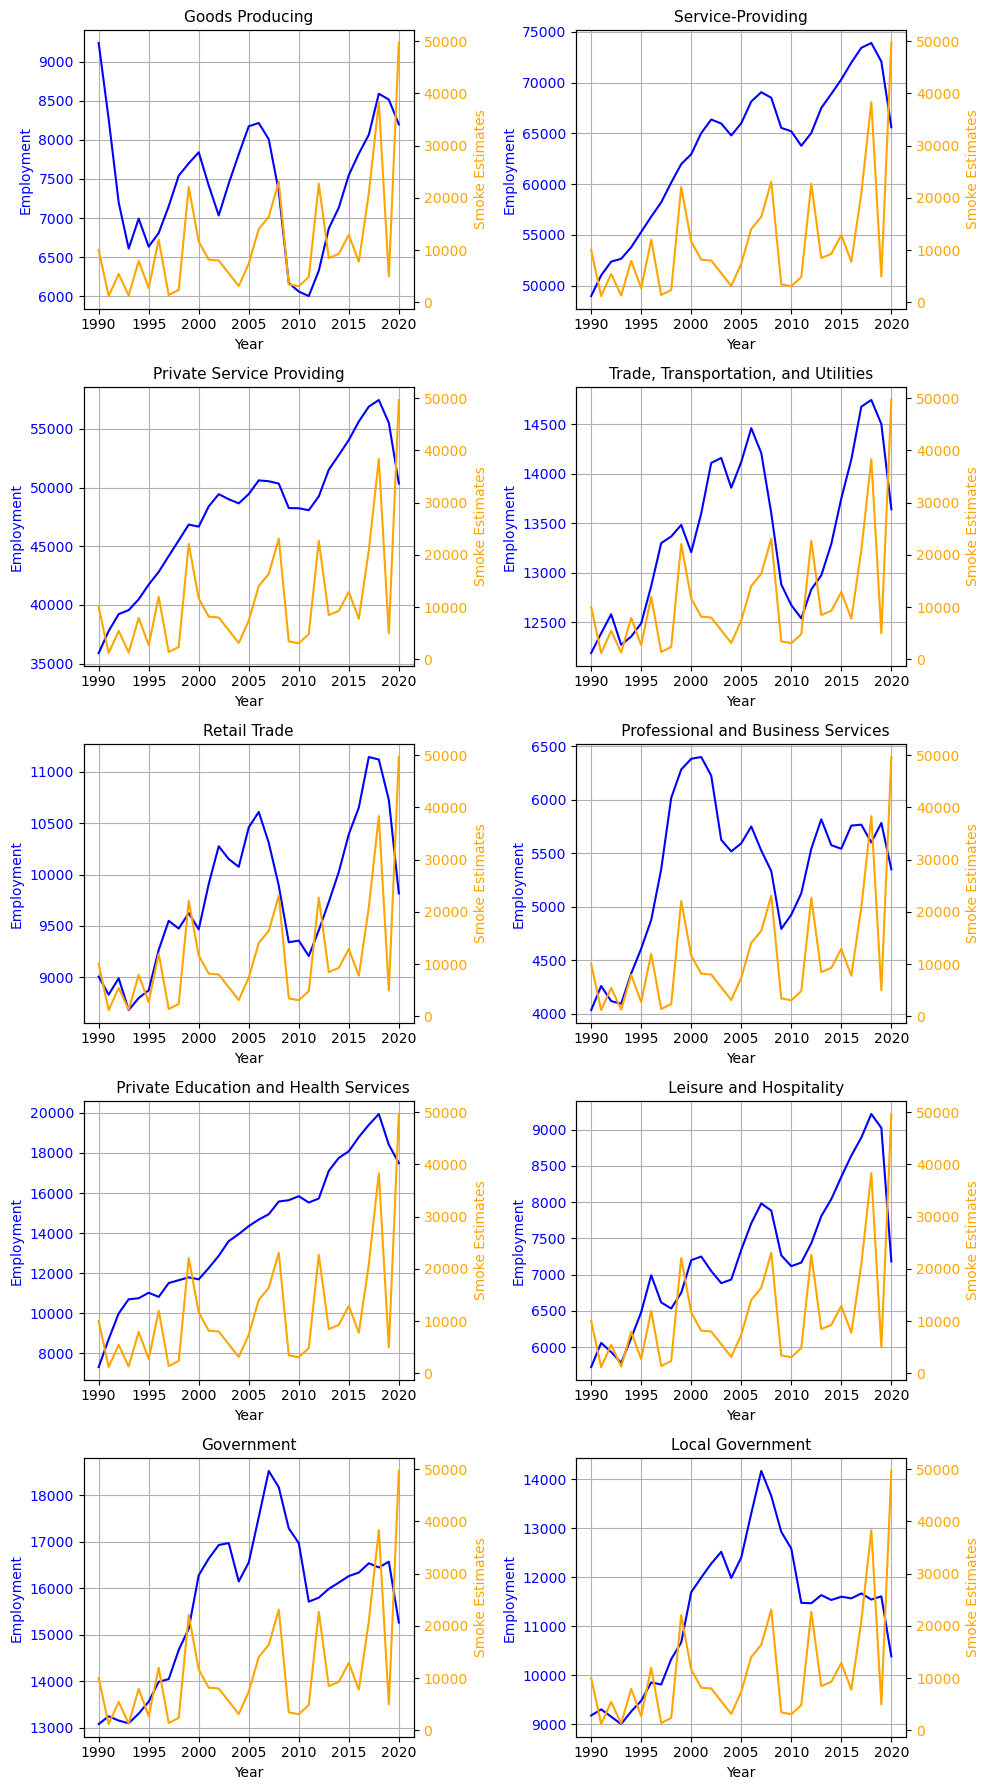

In [13]:
final_df = filtered_merged_df.copy()
industries = final_df['Industry Title'].unique()

grid_size = (5, 2)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 18))
axes = axes.flatten()

for i, industry in enumerate(industries):
    ax1 = axes[i]  
    df_industry = final_df[final_df['Industry Title'] == industry]
    
    ax1.plot(df_industry['Year'], df_industry['Current Employment'], label='Employment', color='blue')
    ax1.set_xlabel('Year', fontsize=10)
    ax1.set_ylabel('Employment', fontsize=10, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(df_industry['Year'], df_industry['Smoke_Estimates'], label='Smoke Estimates', color='orange')
    ax2.set_ylabel('Smoke Estimates', fontsize=10, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    ax1.set_title(industry, fontsize=11)
    ax1.grid(True)

# hide extra graphs
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


### Does wildfire smoke have a significant effect on the county’s employment rates?

In [14]:
# take Total, All Industries
all_industries_df = merged_df[merged_df['Industry Title'] == 'Total, All Industries']
all_industries_df = all_industries_df.dropna(subset=['Smoke_Estimates'])

all_industries_df['Smoke_Estimates'].corr(all_industries_df['Current Employment'])


0.4289575599442375

In [15]:
r, p = stats.pearsonr(all_industries_df['Smoke_Estimates'], all_industries_df['Current Employment'])
print("{}, {}".format(r, p))

0.42895755994423745, 0.016044519395604796


### Which industries are most impacted by wildfire events in terms of employment?


In [16]:
def calc_corr_pval(group):
    r, p = stats.pearsonr(group['Smoke_Estimates'], group['Current Employment'])
    return pd.Series({'Smoke_Employment_Correlation': r, 'p_value': p})

corr_pval_df = final_df.groupby('Industry Title').apply(calc_corr_pval).reset_index()

significant_corr_emp_df = corr_pval_df[corr_pval_df['p_value']<0.05] # filter to significant results
significant_corr_emp_df

,Industry Title,Smoke_Employment_Correlation,p_value
0,Leisure and Hospitality,0.404771,0.023901
1,Private Education and Health Services,0.444033,0.012337
6,Private Service Providing,0.414967,0.020273
7,Retail Trade,0.383840,0.033029
8,Service-Providing,0.390932,0.029664
9,"Trade, Transportation, and Utilities",0.379252,0.035366


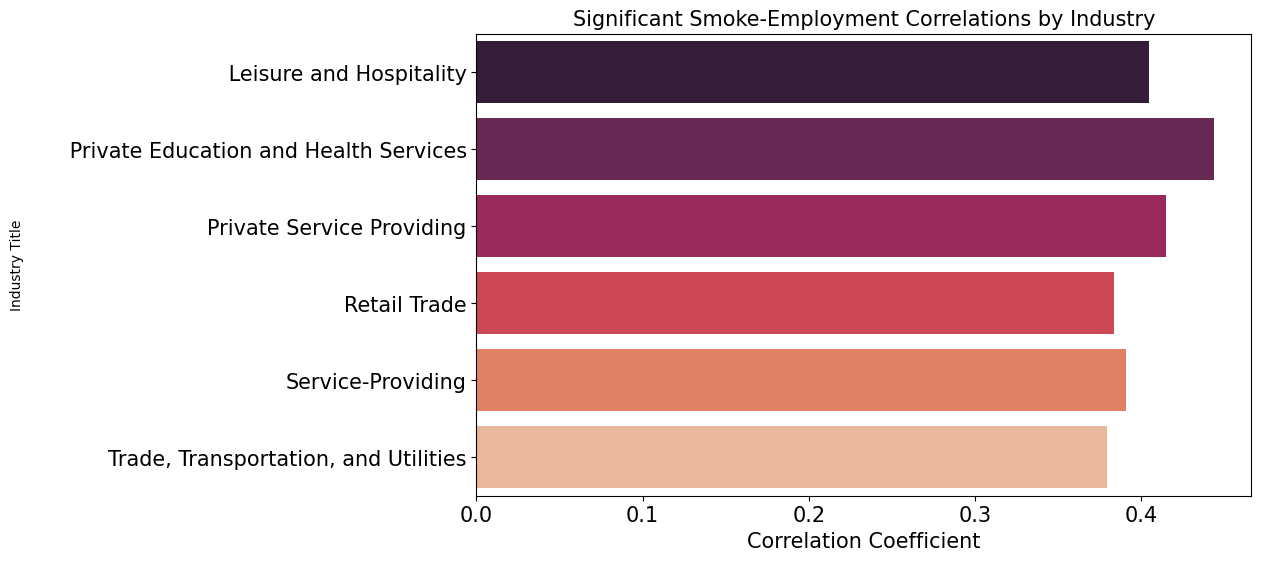

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=significant_corr_emp_df, x='Smoke_Employment_Correlation', y='Industry Title', palette='rocket')
plt.title('Significant Smoke-Employment Correlations by Industry', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

From the results between smoke estimates and employment across various industries. Leisure and Hospitality, Private Education and Health Services, Private Service Providing, Retail Trade, Service-Providing, and Trade, Transportation, and Utilities all show moderate positive correlations, with coefficients around 0.4. Interestingly, this indicates that increased smoke estimates generally correspond to higher employment levels in these sectors.

## Lag Analysis
Wildfire impacts might not be immediate. We explore lagged effects where employment impacts might occur 1 year after the wildfire events.

In [18]:
# create column for lagged employment (1 year), associating next year's employment with the current year.
lagged_final_df = final_df.copy()
lagged_final_df[f'Employment_Lagged_1'] = lagged_final_df['Current Employment'].shift(-10)

In [19]:
def calc_corr_pval_lag(group):
    group = group.dropna(subset=[f'Employment_Lagged_1'])
    r, p = stats.pearsonr(group[f'Smoke_Estimates'], group['Employment_Lagged_1'])
    return pd.Series({'Smoke_Est_Emp_Correlation': r, 'p_value': p})

corr_pval_lag_df = lagged_final_df.groupby('Industry Title').apply(calc_corr_pval_lag).reset_index()
corr_pval_lag_df
#corr_pval_lag_df[corr_pval_lag_df['p_value']<0.05]


,Industry Title,Smoke_Est_Emp_Correlation,p_value
0,Leisure and Hospitality,0.568991,0.001034
1,Private Education and Health Services,0.414434,0.022788
2,Professional and Business Services,0.273251,0.144006
3,Goods Producing,0.286218,0.125189
4,Government,0.403522,0.027018
5,Local Government,0.338816,0.067023
6,Private Service Providing,0.451029,0.012366
7,Retail Trade,0.364316,0.047786
8,Service-Providing,0.460331,0.010476
9,"Trade, Transportation, and Utilities",0.337655,0.068025


## Load GDP Data
https://california.reaproject.org/data-tables/gsp-a900n/tools/60007/

In [20]:
gdp_df = pd.read_csv('data/butte_gdp.csv')
gdp_df = gdp_df.drop(columns=['Unnamed: 1'])
gdp_df = pd.melt(
    gdp_df,
    id_vars=['Unnamed: 0'],
    var_name='Year',
    value_name='GDP'
)
gdp_df.rename(columns={'Unnamed: 0': 'Industry'}, inplace=True)
gdp_df['Year'] = pd.to_numeric(gdp_df['Year'])
gdp_df['GDP'] = pd.to_numeric(gdp_df['GDP'].str.replace(",", ""), errors='coerce')


# join with smoke data
gdp_smoke_df = pd.merge(gdp_df, smoke_df, how='left', 
                     left_on='Year', right_on='Fire_Year')


gdp_smoke_df = gdp_smoke_df[['Year', 'Industry', 'GDP', 'Smoke_Estimates']]
gdp_smoke_df = gdp_smoke_df.dropna()

# take Total, All Industries
all_industries_gdp_df = gdp_smoke_df[gdp_smoke_df['Industry'] == 'All industry total']
all_industries_gdp_df = all_industries_gdp_df.dropna(subset=['Smoke_Estimates'])

r, p = stats.pearsonr(all_industries_gdp_df['Smoke_Estimates'], all_industries_gdp_df['GDP'])
print(f"The correlation coefficient between Smoke Estimates and GDP for All Industries is {r:.4f}, "
      f"with a p-value of {p:.4f}.")


The correlation coefficient between Smoke Estimates and GDP for All Industries is 0.4384, with a p-value of 0.0532.


In [21]:
# the county's primary industries (top 10) based on GDP
industry_total_GDP = gdp_smoke_df.groupby('Industry')['GDP'].sum()

# filter out industries that include the word "Total"
filter_industries = industry_total_GDP[~industry_total_GDP.index.str.contains("Total", case=False)]

top_GDP_industries = filter_industries.sort_values(ascending=False).head(10).index.tolist()
print("Butte county's top 10 industries (based on GDP) are: {}".format(top_GDP_industries))

Butte county's top 10 industries (based on GDP) are: ['        Private industries', '                Finance, insurance, real estate, rental, and leasing', '        Government', '                        Real estate and rental and leasing', '                Educational services, health care, and social assistance', '                        Health care and social assistance', '                Retail trade', '                Professional and business services', '                Construction', '                Manufacturing']


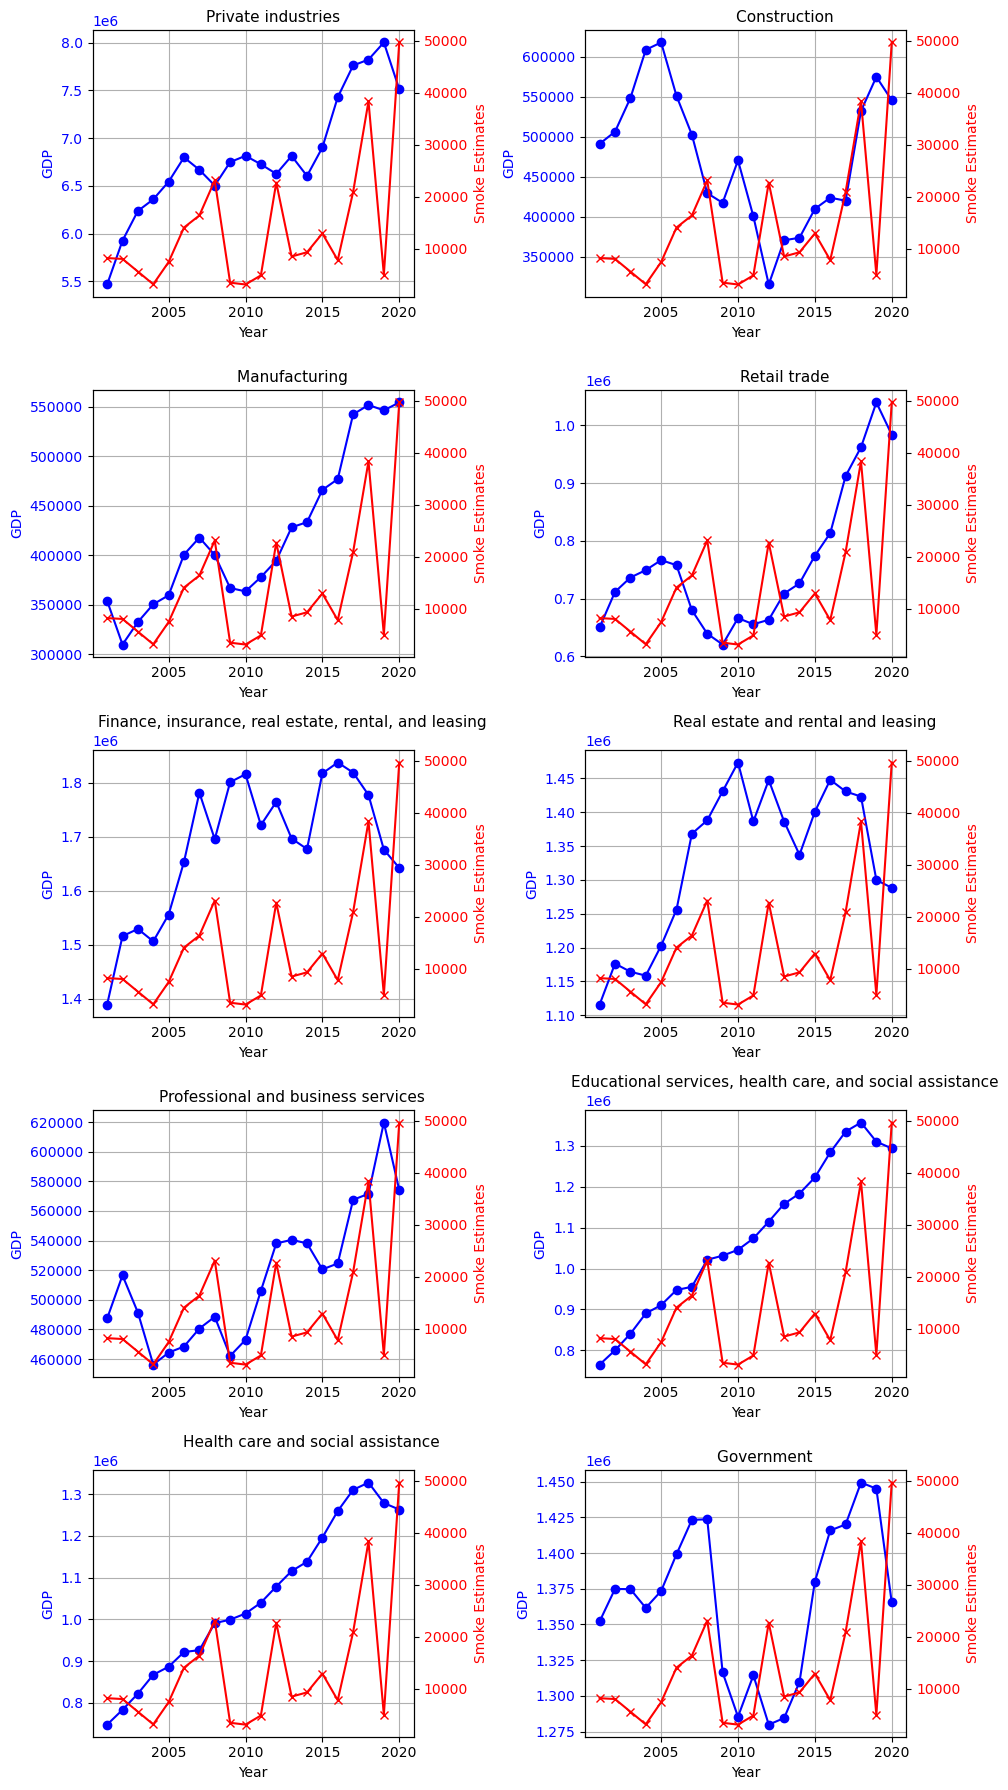

In [22]:
# filter merged_df to top 10 industries only
filtered_gdp_smoke_df = gdp_smoke_df[gdp_smoke_df['Industry'].isin(top_GDP_industries)]

final_gdp_df = filtered_gdp_smoke_df.copy()
industries = final_gdp_df['Industry'].unique()

grid_size = (5, 2)
fig, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 18))
axes = axes.flatten()

for i, industry in enumerate(industries):
    ax1 = axes[i]  
    df_industry = final_gdp_df[final_gdp_df['Industry'] == industry]
    
    ax1.plot(df_industry['Year'], df_industry['GDP'], label='GDP', color='blue', marker='o')
    ax1.set_xlabel('Year', fontsize=10)
    ax1.set_ylabel('GDP', fontsize=10, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(df_industry['Year'], df_industry['Smoke_Estimates'], label='Smoke Estimates', color='red', marker='x')
    ax2.set_ylabel('Smoke Estimates', fontsize=10, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.set_title(industry, fontsize=11)
    ax1.grid(True)

# hide extra graphs
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [23]:
def calc_corr_pval(group):
    r, p = stats.pearsonr(group['Smoke_Estimates'], group['GDP'])
    return pd.Series({'Smoke_GDP_Correlation': r, 'p_value': p})

corr_pval_gdp_df = final_gdp_df.groupby('Industry').apply(calc_corr_pval).reset_index()

significant_corr_gdp_df = corr_pval_gdp_df[corr_pval_gdp_df['p_value']< 0.05]
significant_corr_gdp_df

,Industry,Smoke_GDP_Correlation,p_value
0,Health care and social...,0.483576,0.030759
3,"Educational services, health c...",0.478427,0.032854
5,Manufacturing,0.625458,0.003185
6,Professional and business serv...,0.466062,0.038339
7,Retail trade,0.492894,0.027236


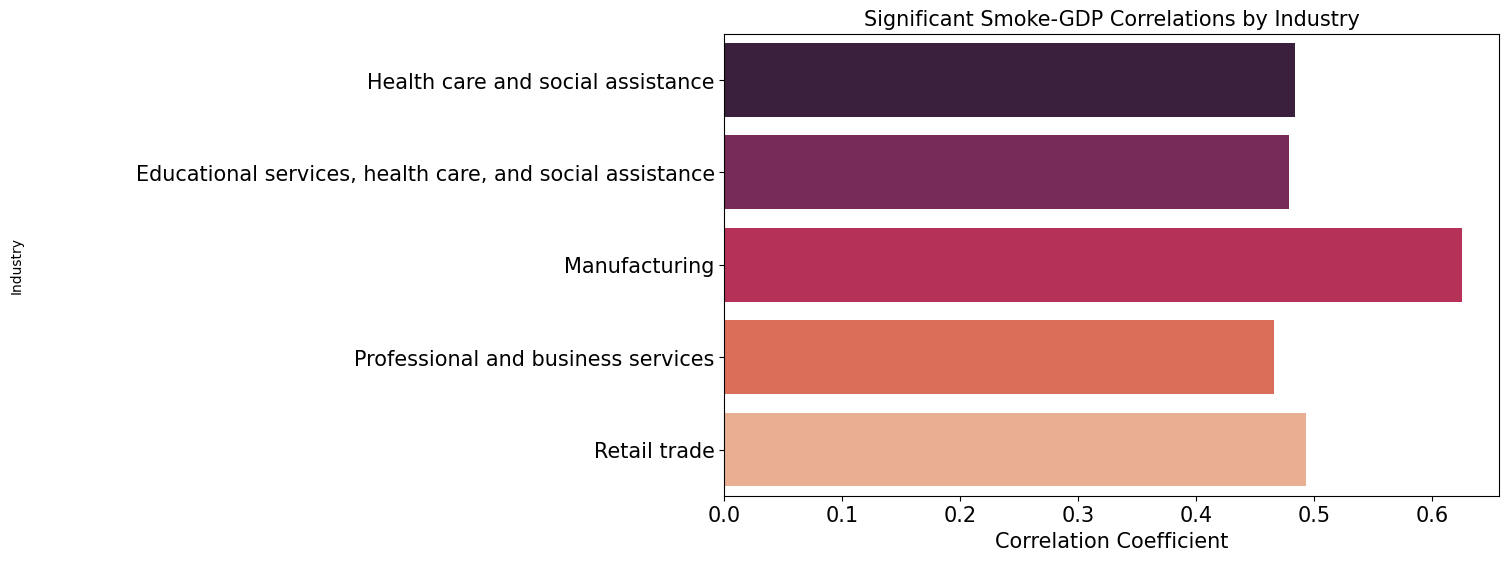

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=significant_corr_gdp_df, x='Smoke_GDP_Correlation', y='Industry', palette='rocket')
plt.title('Significant Smoke-GDP Correlations by Industry', fontsize=15)
plt.xlabel('Correlation Coefficient', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [25]:
# create column for lagged employment (1 year), associating the next year's GDP with the current year.
lagged_final_gdp_df = final_gdp_df.copy()
lagged_final_gdp_df[f'GDP_Lagged_1'] = lagged_final_gdp_df['GDP'].shift(-10)

lagged_final_gdp_df

def calc_corr_pval_lag_gdp(group):
    group = group.dropna(subset=[f'GDP_Lagged_1'])
    r, p = stats.pearsonr(group[f'Smoke_Estimates'], group['GDP_Lagged_1'])
    return pd.Series({'Smoke_Est_GDP_lag_1_Correlation': r, 'p_value': p})

corr_pval_lag_gdp_df = lagged_final_gdp_df.groupby('Industry').apply(calc_corr_pval_lag_gdp).reset_index()
corr_pval_lag_gdp_df

,Industry,Smoke_Est_GDP_lag_1_Correlation,p_value
0,Health care and social...,0.367017,0.122176
1,Real estate and rental...,0.183765,0.451400
2,Construction,0.029365,0.905011
3,"Educational services, health c...",0.370554,0.118346
4,"Finance, insurance, real estat...",0.197956,0.416575
5,Manufacturing,0.410262,0.081047
6,Professional and business serv...,0.459645,0.047710
7,Retail trade,0.350115,0.141699
8,Government,0.359286,0.130854
9,Private industries,0.471875,0.041374


Interestingly, the correlations between wildfire smoke estimates and both GDP and employment across various industries are moderately positive. 

Specifically, industries such as health care, manufacturing, professional and business services, and retail trade show positive correlations with GDP. 

Similarly, sectors like leisure and hospitality, private education and health services, service providing, retail trade, and trade, transportation, and utilities exhibit positive correlations with employment.


This suggests that certain industries may experience economic benefits from the increased activity associated with recovery and rebuilding efforts following wildfire events, despite the immediate negative impacts of wildfires and smoke exposure. 
